# Describe My Environment - Interactive Demo

This notebook demonstrates the **Describe My Environment** system.

## How It Works

This notebook provides a **condensed, interactive version** of our full Python pipeline. While the full system (run via `python run.py`) uses multi-threading for maximum performance, this notebook runs sequentially to let you inspect the internal states.

### The Pipeline
1.  **Reflex Loop (Fast)**: Uses YOLO11 to detect objects and track their movement in real-time. It monitors for approaching hazards (e.g., a person walking toward you) and issues immediate "STOP" warnings.
2.  **Cognitive Loop (Smart)**: When you press **Spacebar**, it captures the current frame, uses **BLIP** to generate a visual caption, and sends it along with object tracking data to **Llama 3.2**. The LLM synthesizes this into a helpful narration.

### Limitations & Hallucinations
*   **"Mirror" Hallucinations**: The model sometimes thinks a person facing the camera is looking into a mirror. We have added logic to correct this to "facing the camera".
*   **"Bathroom" Confusion**: White tiled walls often confuse the scene captioner into thinking it's in a bathroom. We sanitize this to "room" for safety.
*   **Object Persistence**: In this demo, if an object disappears for a split second, it might be re-detected as a new object. The full pipeline handles this more robustly.

### Running the Full System
For the complete, high-performance experience with proper threading and robustness, please run the main script in your terminal:
```bash
python run.py
```

In [9]:
# Setup and Imports
import os
import sys
import cv2
import time
import threading
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Add project root to path
project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.reflex_loop.tracker import YOLOTracker
from src.reflex_loop.safety import SafetyMonitor
from src.reflex_loop.physics import PhysicsEngine
from src.cognitive_loop.scene_composer import SceneComposer
from src.cognitive_loop.narrator import LLMNarrator
from src.cognitive_loop.history import HistoryBuffer
from src.hardware.audio import AudioHandler
from src.config import GLOBAL_WARNING_COOLDOWN

print("✅ Imports complete")

✅ Imports complete


In [10]:
def run_image_test():
    print("\n--- Running Static Image Test ---")
    
    # Initialize Components
    print("⏳ Initializing components...")
    tracker = YOLOTracker(model_path="yolo11n.pt")
    scene_composer = SceneComposer()
    narrator = LLMNarrator()
    audio_handler = AudioHandler()
    
    # Load Image
    image_path = os.path.join("test_images", "test_image_0.jpg")
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return
        
    frame = cv2.imread(image_path)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # 1. Tracking
    detections = tracker.detect(frame)
    print(f"✅ Detected {len(detections)} objects")
    
    # Visualize
    annotated_frame = frame_rgb.copy()
    for det in detections:
        x1, y1, x2, y2 = det.box
        label = f"{det.class_name} {det.confidence:.2f}"
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(annotated_frame)
    plt.axis('off')
    plt.title("Detections")
    plt.show()
    
    # 2. Scene Description
    caption = scene_composer.generate_scene_description(frame)
    print(f"\n📝 Scene: {caption}")
    
    # 3. Narration
    # Prepare strings for compose_prompt
    object_descriptions = [
        f"{d.class_name} (conf: {d.confidence:.2f})" for d in detections
    ]
    
    print("\n🤖 Generating Narration...")
    
    # Use compose_prompt to create the string prompt for generate_narration
    prompt = narrator.compose_prompt(caption, object_descriptions)
    narration = narrator.generate_narration(prompt)
    
    if narration:
        print(f"\n🗣️ FINAL NARRATION: {narration}")
        audio_handler.speak_text(narration)
    else:
        print("⚠️ Could not generate narration (check Ollama)")
        
    # Allow time for audio to play before cleanup
    time.sleep(5)
    audio_handler.stop()

In [11]:
def run_camera_demo():
    print("\n--- Running Live Camera Demo ---")
    print("⏳ Initializing pipeline components...")
    
    tracker = YOLOTracker(model_path="yolo11n.pt")
    scene_composer = SceneComposer()
    narrator = LLMNarrator()
    safety_monitor = SafetyMonitor()
    history_buffer = HistoryBuffer()
    audio_handler = AudioHandler()
    physics_engine = PhysicsEngine()
    
    if not narrator.check_connection():
        print("⚠️ Ollama is not running. Narration will be disabled.")
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("❌ Could not open camera.")
        return
        
    # Get frame dimensions
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print("✅ Camera started.")
    print("Commands:")
    print(" [Space] - Generate scene narration")
    print(" [q]     - Quit")

    frame_count = 0
    last_hazard_time = 0
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            timestamp = time.time()
            frame_count += 1
            
            # 1. Reflex Loop: Tracking
            detections, annotated_frame = tracker.track(frame, frame_count, timestamp, return_annotated=True)
            
            # Update History
            for det in detections:
                track_id = det.track_id if det.track_id is not None else -1
                history_buffer.add_detection(track_id, det)
            
            history_buffer.cleanup_stale_objects(frame_count)
            
            # 2. Hazard Detection
            hazards = safety_monitor.check_hazards(detections, history_buffer)
            if safety_monitor.should_warn(hazards):
                current_time = time.time()
                # Add cooldown to prevent spamming the audio queue
                if current_time - last_hazard_time > GLOBAL_WARNING_COOLDOWN:
                    warning = safety_monitor.get_warning_message(hazards)
                    print(f"⚠️ HAZARD: {warning}")
                    audio_handler.play_beep()
                    audio_handler.speak_text(warning, priority=True)
                    last_hazard_time = current_time
                
                # Visual warning always shows
                cv2.putText(annotated_frame, "HAZARD DETECTED", (50, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

            # Show Frame
            cv2.imshow("Describe My Environment - Demo", annotated_frame)
            
            # Input Handling
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == 32:  # Spacebar for narration
                print("\n📸 Creating narration...")
                
                # Run narration logic
                caption = scene_composer.generate_scene_description(frame)
                print(f"   📝 BLIP Caption: {caption}")
                
                # Format objects for the prompt with motion data
                # IMPORTANT: We do NOT use 'box coordinates' in the text sent to LLM to avoid hallucinations
                object_descriptions = []
                for d in detections:
                    obj_desc = f"{d.class_name}"
                    
                    # Add motion context if tracked
                    motion_tag = "(stationary)"
                    if d.track_id is not None:
                        tracked_obj = history_buffer.get_object(d.track_id)
                        if tracked_obj:
                            # Check if approaching center
                            is_approaching = physics_engine.is_approaching_center(tracked_obj, frame_width, frame_height)
                            # Check if expanding (getting closer)
                            growth = physics_engine.calculate_area_growth(tracked_obj)
                            
                            if is_approaching and growth > 10.0:
                                motion_tag = "(approaching you)"
                            elif growth < -10.0:
                                motion_tag = "(moving away)"
                            else:
                                # Calculate simple left/right movement
                                vel_x, _ = physics_engine.calculate_velocity(tracked_obj)
                                if vel_x > 2.0:
                                    motion_tag = "(moving right)"
                                elif vel_x < -2.0:
                                    motion_tag = "(moving left)"
                    
                    obj_desc += f" {motion_tag}"
                    object_descriptions.append(obj_desc)

                if hazards:
                    hazard_descriptions = [str(h.reason) for h in hazards]
                    object_descriptions.append(f"Hazards: {hazard_descriptions}")
                
                # Compose the single string prompt
                prompt = narrator.compose_prompt(caption, object_descriptions)
                print(f"   📤 Sending Prompt to Llama: \n{'-'*20}\n{prompt}\n{'-'*20}")
                
                # Generate narration
                print("🤔 Thinking...")
                narration = narrator.generate_narration(prompt)
                
                if narration:
                    print(f"🗣️ {narration}")
                    audio_handler.speak_text(narration)
                
    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        cv2.destroyAllWindows()
        audio_handler.stop()
        print("🛑 Stopped.")

Select Mode:
1. Static Test Image
2. Live Camera Demo

--- Running Static Image Test ---
⏳ Initializing components...
✅ Detected 4 objects


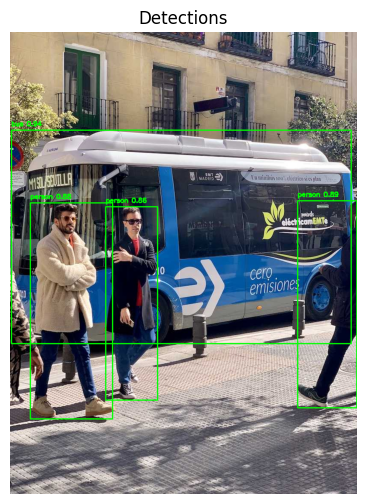


📝 Scene: a group of people standing in front of a bus

🤖 Generating Narration...

🗣️ FINAL NARRATION: There's a bus and three people standing in front of it.


: 

In [ ]:
# Main Execution
print("Select Mode:")
print("1. Static Test Image")
print("2. Live Camera Demo")

choice = input("Enter choice (1 or 2): ")

if choice == '2':
    run_camera_demo()
else:
    run_image_test()